<a href="https://colab.research.google.com/github/matsunagalab/lecture_ML/blob/main/machine_learning_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7回 識別その3: 決定木とアンサンブル学習

## iris data set を 決定木(decision tree)で識別

Accuracy: 0.9


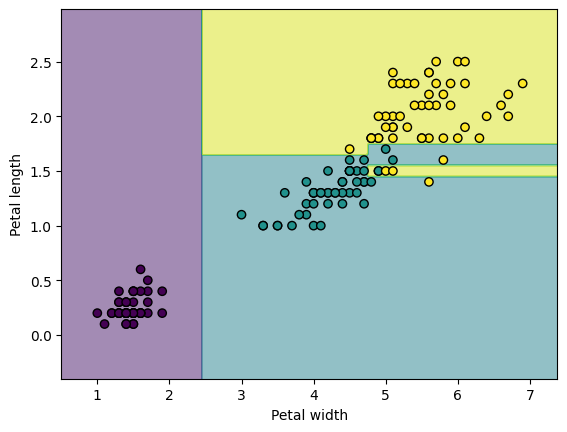

In [26]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# load iris data
iris = load_iris()
X = iris.data
y = iris.target

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# create instance of decision tree
model = DecisionTreeClassifier(criterion='gini', random_state=123)

# train the model
model.fit(X_train, y_train)

# make prediction
y_pred = model.predict(X_test)

# evaluate the prediction accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# visualize decision boundary
# ranges of Petal width and Petal length
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
a_min, a_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5
b_min, b_max = X[:, 3].min() - 0.5, X[:, 3].max() + 0.5

# create mesh grids
xx, yy, aa, bb = np.meshgrid(X[:, 0].mean(),
                             X[:, 1].mean(), 
                             np.arange(a_min, a_max, 0.02),
                             np.arange(b_min, b_max, 0.02))

# make predictions on the mesh grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel(), aa.ravel(), bb.ravel()])

# visualize the predictions
Z = Z.reshape(xx.shape)
plt.contourf(np.squeeze(aa), np.squeeze(bb), np.squeeze(Z), alpha=0.5)
plt.scatter(X[:, 2], X[:, 3], c=y, edgecolors='k')
plt.xlabel('Petal width')
plt.ylabel('Petal length')
plt.show()


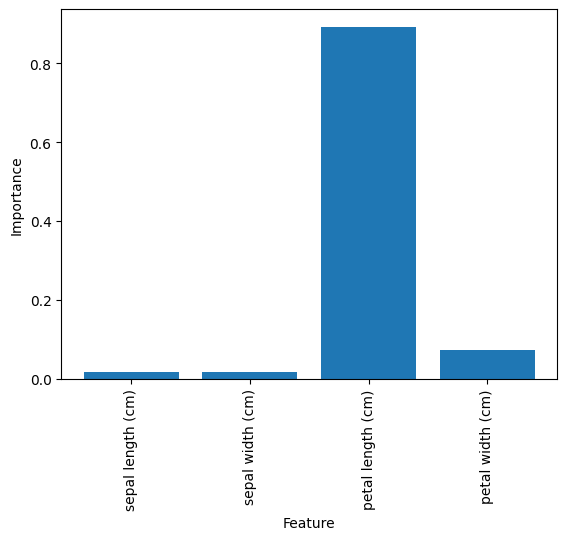

In [27]:
# visualize feature importance
import matplotlib.pyplot as plt

# get the feature importance
importance = model.feature_importances_

# plot the feature importance
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), iris.feature_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## iris data set を random forestで識別

Accuracy: 0.9666666666666667


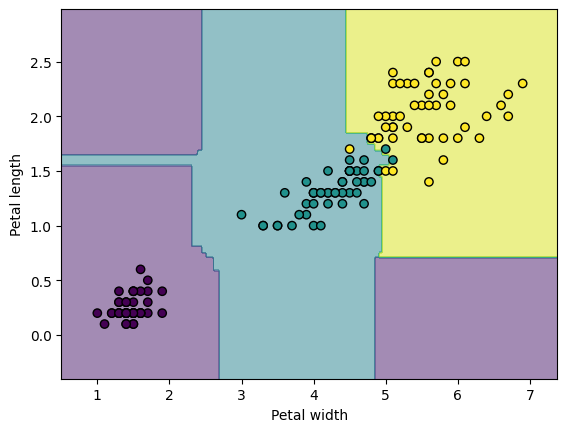

In [28]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# load iris data
iris = load_iris()
X = iris.data
y = iris.target

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# create instance of Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=123)

# train the model
model.fit(X_train, y_train)

# make prediction
y_pred = model.predict(X_test)

# evaluate the prediction accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# visualize decision boundary
# ranges of Petal width and Petal length
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
a_min, a_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5
b_min, b_max = X[:, 3].min() - 0.5, X[:, 3].max() + 0.5

# create mesh grid
xx, yy, aa, bb = np.meshgrid(X[:, 0].mean(),
                             X[:, 1].mean(), 
                             np.arange(a_min, a_max, 0.02),
                             np.arange(b_min, b_max, 0.02))

# make predictions on the mesh grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel(), aa.ravel(), bb.ravel()])

# visualize the predictions
Z = Z.reshape(xx.shape)
plt.contourf(np.squeeze(aa), np.squeeze(bb), np.squeeze(Z), alpha=0.5)
plt.scatter(X[:, 2], X[:, 3], c=y, edgecolors='k')
plt.xlabel('Petal width')
plt.ylabel('Petal length')
plt.show()


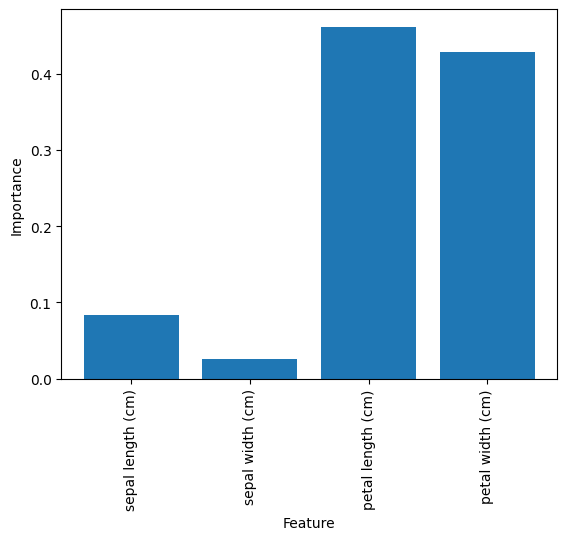

In [29]:
# visualize feature importance
import matplotlib.pyplot as plt

# get the feature importance
importance = model.feature_importances_

# plot the feature importance
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), iris.feature_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## iris data setを勾配ブースティング法(XGBoost)で識別

XGBoostはパラメータがたくさんあって、人間が適切なパラメータを選ぶのが難しいので、Optunaというパッケージでうまくいくつかのパラメータで試行錯誤してもらい適切なものを選んでもらうようにします

In [30]:
# Install XGBoost and Optuna 
!pip install xgboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import optuna

# load iris data
iris = load_iris()
X, y = iris.data, iris.target

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1, log=True)
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# tune hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# print the best parameters
print(study.best_params)

# print the best score
print(study.best_value)

# train and evaluate the model with the best parameters
model = xgb.XGBClassifier(**study.best_params)
model.fit(X_train, y_train)

# get feature importance
importance = model.feature_importances_
for i, score in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (iris.feature_names[i], score))

# evaluate the prediction accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[I 2023-05-28 09:43:31,021] A new study created in memory with name: no-name-f521dc94-961a-4019-8ffe-03fd09f59ef5
[I 2023-05-28 09:43:31,128] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 336, 'max_depth': 3, 'learning_rate': 1.957316128280997e-05, 'subsample': 0.9099986379114503, 'colsample_bytree': 0.8625350344848821}. Best is trial 0 with value: 1.0.
[I 2023-05-28 09:43:31,255] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 405, 'max_depth': 5, 'learning_rate': 2.521767805401382e-05, 'subsample': 0.9454502018616402, 'colsample_bytree': 0.6565550544393958}. Best is trial 0 with value: 1.0.
[I 2023-05-28 09:43:31,921] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 382, 'max_depth': 5, 'learning_rate': 0.00027114753748617065, 'subsample': 0.8631398597855144, 'colsample_bytree': 0.7353527494770628}. Best is trial 0 with value: 1.0.
[I 2023-05-28 09:43:34,652] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 348, 

{'n_estimators': 336, 'max_depth': 3, 'learning_rate': 1.957316128280997e-05, 'subsample': 0.9099986379114503, 'colsample_bytree': 0.8625350344848821}
1.0
Feature: sepal length (cm), Score: 0.00581
Feature: sepal width (cm), Score: 0.01960
Feature: petal length (cm), Score: 0.50067
Feature: petal width (cm), Score: 0.47393
Accuracy: 100.00%


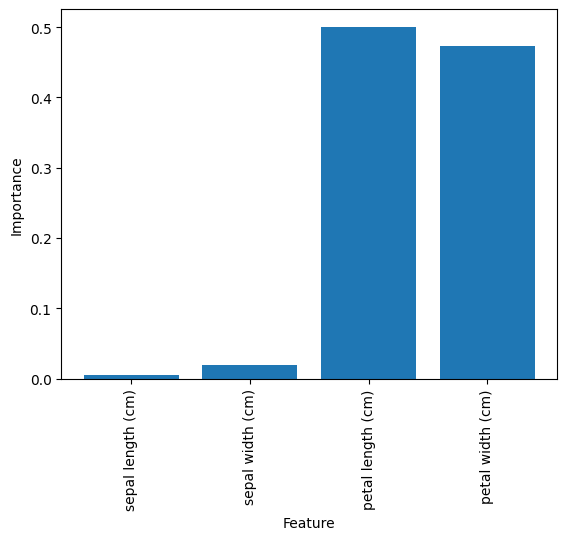

In [32]:
# visualize feature importance
import matplotlib.pyplot as plt

# get the feature importance
importance = model.feature_importances_

# plot the feature importance
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), iris.feature_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## MNIST data setを勾配ブースティング法(XGBoost)で識別

In [24]:
import xgboost as xgb
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna

# load digits data
digits = load_digits()
X, y = digits.data, digits.target

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the objective function for optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1, log=True)
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# tune hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# print the best parameters
print("Best parameters: ", study.best_params)

# print the best score
print("Best accuracy: ", study.best_value)

# train and evaluate the model with the best parameters
model = xgb.XGBClassifier(**study.best_params)
model.fit(X_train, y_train)

# evaluate the prediction accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[I 2023-05-28 09:41:50,286] A new study created in memory with name: no-name-7a4ba9fc-bf68-43ce-b1e9-09e603904cf4
[I 2023-05-28 09:42:18,499] Trial 0 finished with value: 0.95 and parameters: {'n_estimators': 266, 'max_depth': 7, 'learning_rate': 0.002083868704052624, 'subsample': 0.9705212023735421, 'colsample_bytree': 0.9625399572014319}. Best is trial 0 with value: 0.95.
[I 2023-05-28 09:42:20,622] Trial 1 finished with value: 0.9611111111111111 and parameters: {'n_estimators': 111, 'max_depth': 8, 'learning_rate': 1.7676402941923e-05, 'subsample': 0.967119776460726, 'colsample_bytree': 0.5055303542376025}. Best is trial 1 with value: 0.9611111111111111.
[I 2023-05-28 09:42:25,309] Trial 2 finished with value: 0.9416666666666667 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 9.870270075595317e-05, 'subsample': 0.7216754725345575, 'colsample_bytree': 0.9448896856175111}. Best is trial 1 with value: 0.9611111111111111.
[I 2023-05-28 09:42:39,721] Trial 3 finish

Best parameters:  {'n_estimators': 493, 'max_depth': 3, 'learning_rate': 0.03899332252807714, 'subsample': 0.9002390360970174, 'colsample_bytree': 0.8196283913025438}
Best accuracy:  0.975
Accuracy: 97.50%


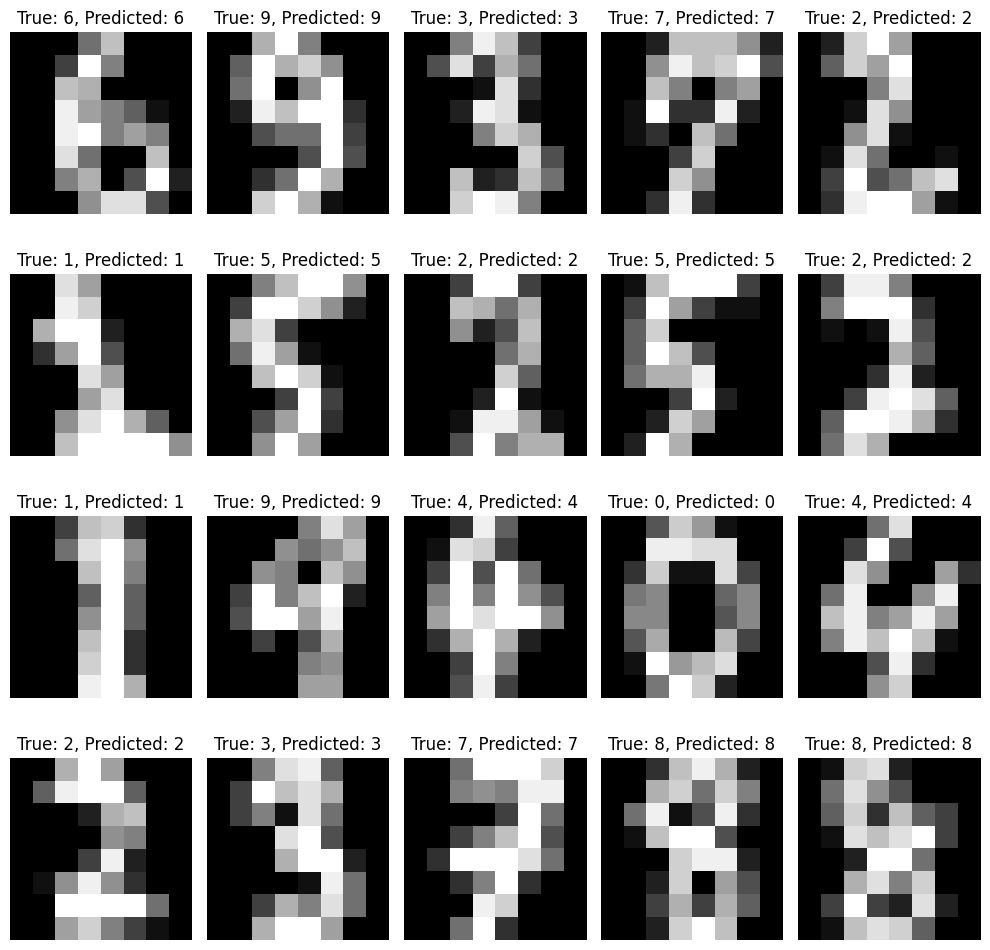

In [25]:
# show prediction and labels with images
import matplotlib.pyplot as plt

# get predictions on test data
y_pred = model.predict(X_test)

# select first 20 images from the test data
images = X_test[:20]
predicted_labels = y_pred[:20]
true_labels = y_test[:20]

# plot the images and their predicted labels
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].reshape((8, 8)), cmap='gray')
    plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
